# Análisis de la Eficacia de los Operadores de CallMeMaybe

## Introducción

El servicio de telefonía virtual CallMeMaybe necesita desarrollar una nueva función que brinde a los supervisores y las supervisores información sobre los operadores menos eficaces. 

Se considera que un operador es ineficaz si tiene una gran cantidad de llamadas entrantes perdidas (internas y externas) y un tiempo de espera prolongado para las llamadas entrantes. Además, si se supone que un operador debe realizar llamadas salientes, un número reducido de ellas también será un signo de ineficacia.

Para crear esta función, vamos a probar la hipótesis que la eficacia estimada de los distintos operadores que utiliza CallMeMaybe es diferente, y vamos a analizar la relación entre los marcadores de eficacia (eficacia y dirección de llamada, cantidad de llamadas, tiempos de espera, etc.) 

Disponemos de los siguientes datos de los archivos telecom_dataset_us.csv y telecom_clients_us.csv:

-   El dataset comprimido `telecom_dataset_us.csv` contiene las siguientes columnas:

    - `user_id`: ID de la cuenta de cliente
    - `date`: fecha en la que se recuperaron las estadísticas
    - `direction`: "dirección" de llamada (`out` para saliente, `in` para entrante)
    - `internal`: si la llamada fue interna (entre los operadores de un cliente o clienta)
    - `operator_id`: identificador del operador
    - `is_missed_call`: si fue una llamada perdida
    - `calls_count`: número de llamadas
    - `call_duration`: duración de la llamada (sin incluir el tiempo de espera)
    - `total_call_duration`: duración de la llamada (incluido el tiempo de espera)

-   El conjunto de datos `telecom_clients_us.csv` tiene las siguientes columnas:

    - `user_id`: ID de usuario/a
    - `tariff_plan`: tarifa actual de la clientela
    - `date_start`: fecha de registro de la clientela

A partir de la información que tenemos, vamos a llevar a cabo las etapas: 

**Parte 1:** descargar librerias y paquetes

**Parte 2:** guardar datos de los datasets y preprocesarlos

**Parte 3:** Análisis Exploratorio de Datos (EDA)

**Parte 4:** Probar las hipótesis estadísticamente

**Parte 5:** Conclusiones finales y recomendaciones para CallMeMaybe (ver enlace a presentación final PDF)

## Paso 1: Descargar librerías y paquetes

In [148]:
# descargar librerías y paquetes

import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import seaborn as sns


## Paso 2: Guardar datos y Preprocesamiento

Objetivos:
- Comprobar la exactitud de los nombres de columnas y renombrar si necesario
- Convertir tipos de datos de columnas para su análisis adecuado
- Estudiar valores ausentes y reemplazar si necesario
- Estudiar valores duplicados y eliminar si necesario
- Estudiar el tipo de correspondencia

In [117]:
# guardar datasets: telecom_clients_us.csv

telecom_clients = pd.read_csv(r"C:\Users\david\Documents\Programacion\Practicum - Data Analyst\TripleTen-Final-Project\EDA Telecomunicaciones\telecom_clients_us.csv")

print(telecom_clients.info())

display(telecom_clients.head(5))

print(telecom_clients.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB
None


,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


             user_id
count     732.000000
mean   167431.927596
std       633.810383
min    166373.000000
25%    166900.750000
50%    167432.000000
75%    167973.000000
max    168606.000000


In [135]:
# convertimos tipos de datos en columna 'date_start' de object a datetime

telecom_clients['date_start'] = pd.to_datetime(telecom_clients['date_start'], format="%Y-%m-%d")

telecom_clients['date_start'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 732 entries, 0 to 731
Series name: date_start
Non-Null Count  Dtype         
--------------  -----         
732 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 5.8 KB


In [5]:
# guardar datasets: telecom_dataset_us.csv

telecom_dataset = pd.read_csv(r"C:\Users\david\Documents\Programacion\Practicum - Data Analyst\TripleTen-Final-Project\EDA Telecomunicaciones\telecom_dataset_us.csv")

print(telecom_dataset.info())

display(telecom_dataset.head(5))

print(telecom_dataset.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB
None


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


             user_id    operator_id   calls_count  call_duration  \
count   53902.000000   45730.000000  53902.000000   53902.000000   
mean   167295.344477  916535.993002     16.451245     866.684427   
std       598.883775   21254.123136     62.917170    3731.791202   
min    166377.000000  879896.000000      1.000000       0.000000   
25%    166782.000000  900788.000000      1.000000       0.000000   
50%    167162.000000  913938.000000      4.000000      38.000000   
75%    167819.000000  937708.000000     12.000000     572.000000   
max    168606.000000  973286.000000   4817.000000  144395.000000   

       total_call_duration  
count         53902.000000  
mean           1157.133297  
std            4403.468763  
min               0.000000  
25%              47.000000  
50%             210.000000  
75%             902.000000  
max          166155.000000  


In [6]:
# convertimos tipos de datos en columna 'date' de object a datetime y agregamos una columna que contenga solo la fecha llamada 'date_only'

telecom_dataset['date'] = pd.to_datetime(telecom_dataset['date'], format="%Y-%m-%d %H:%M:%S%z")  # , format="%Y-%m-%d %H:%M:%S%z"
telecom_dataset['date_only'] = pd.to_datetime((telecom_dataset['date'].dt.date), format="%Y-%m-%d")

# convertir columna 'operator_id' de telecom_dataset a category
telecom_dataset['operator_id'] = telecom_dataset['operator_id'].astype('category')

#comprueba
telecom_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype                    
---  ------               --------------  -----                    
 0   user_id              53902 non-null  int64                    
 1   date                 53902 non-null  datetime64[ns, UTC+03:00]
 2   direction            53902 non-null  object                   
 3   internal             53785 non-null  object                   
 4   operator_id          45730 non-null  category                 
 5   is_missed_call       53902 non-null  bool                     
 6   calls_count          53902 non-null  int64                    
 7   call_duration        53902 non-null  int64                    
 8   total_call_duration  53902 non-null  int64                    
 9   date_only            53902 non-null  datetime64[ns]           
dtypes: bool(1), category(1), datetime64[ns, UTC+03:00](1), datetime64[ns](

In [7]:
# lidiar con ausentes en dataset telecom_dataset, en las columnas internal y operator_id

print('\nValores ausentes en la columna internal:')

display(telecom_dataset[telecom_dataset['internal'].isna() == True])

print('\nValores ausentes en la columna operator_id:')

display(telecom_dataset[telecom_dataset['operator_id'].isna() == True])



Valores ausentes en la columna internal:


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_only
1007,166405,2019-09-18 00:00:00+03:00,in,NaN,NaN,True,1,0,59,2019-09-18
1090,166405,2019-10-01 00:00:00+03:00,in,NaN,NaN,True,1,0,1,2019-10-01
1864,166406,2019-08-20 00:00:00+03:00,in,NaN,NaN,True,1,0,36,2019-08-20
1924,166406,2019-09-02 00:00:00+03:00,in,NaN,879898.0,False,1,2,9,2019-09-02
6210,166541,2019-09-26 00:00:00+03:00,in,NaN,908960.0,False,1,393,423,2019-09-26
...,...,...,...,...,...,...,...,...,...,...
52462,168361,2019-11-09 00:00:00+03:00,in,NaN,NaN,True,6,0,14,2019-11-09
52590,168361,2019-11-13 00:00:00+03:00,in,NaN,NaN,True,2,0,6,2019-11-13
52621,168361,2019-11-14 00:00:00+03:00,in,NaN,NaN,True,1,0,2,2019-11-14
53717,168579,2019-11-09 00:00:00+03:00,in,NaN,NaN,True,1,0,18,2019-11-09



Valores ausentes en la columna operator_id:


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_only
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4,2019-08-04
7,166377,2019-08-05 00:00:00+03:00,in,False,NaN,True,6,0,35,2019-08-05
9,166377,2019-08-06 00:00:00+03:00,in,False,NaN,True,4,0,62,2019-08-06
17,166377,2019-08-07 00:00:00+03:00,in,False,NaN,True,2,0,24,2019-08-07
27,166377,2019-08-12 00:00:00+03:00,in,False,NaN,True,2,0,34,2019-08-12
...,...,...,...,...,...,...,...,...,...,...
53876,168601,2019-11-27 00:00:00+03:00,in,False,NaN,True,2,0,39,2019-11-27
53880,168601,2019-11-28 00:00:00+03:00,in,False,NaN,True,1,0,19,2019-11-28
53889,168603,2019-11-28 00:00:00+03:00,in,False,NaN,True,1,0,30,2019-11-28
53893,168606,2019-11-08 00:00:00+03:00,in,False,NaN,True,6,0,121,2019-11-08


In [120]:
# eliminanos los valores ausentes de la columna 'internal'

telecom_dataset = telecom_dataset.dropna(subset='internal')

In [8]:
# valores duplicados 

# telecom_clients

print('Filas duplicadas en dataset telecom_clients:')
display(telecom_clients[telecom_clients.duplicated() == True])

# telecom_dataset

print('Filas duplicadas en dataset telecom_dataset:')
display(telecom_dataset[telecom_dataset[['user_id','date','direction','internal','operator_id','is_missed_call','calls_count','call_duration','total_call_duration']].duplicated() == True])

Filas duplicadas en dataset telecom_clients:


,user_id,tariff_plan,date_start


Filas duplicadas en dataset telecom_dataset:


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_only
8,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50,2019-08-05
28,166377,2019-08-12 00:00:00+03:00,in,False,NaN,True,2,0,34,2019-08-12
44,166377,2019-08-14 00:00:00+03:00,out,False,880026.0,False,10,1567,1654,2019-08-14
45,166377,2019-08-14 00:00:00+03:00,in,False,NaN,True,1,0,3,2019-08-14
51,166377,2019-08-15 00:00:00+03:00,out,False,880026.0,False,11,1413,1473,2019-08-15
...,...,...,...,...,...,...,...,...,...,...
53869,168601,2019-11-25 00:00:00+03:00,in,False,952914.0,False,7,1229,1282,2019-11-25
53874,168601,2019-11-26 00:00:00+03:00,in,False,952914.0,False,4,539,562,2019-11-26
53875,168601,2019-11-26 00:00:00+03:00,in,False,NaN,True,3,0,35,2019-11-26
53885,168603,2019-11-20 00:00:00+03:00,out,False,959118.0,True,3,0,89,2019-11-20


In [9]:
# estudiar correlaciones en ambos datasets

# telecom_dataset

telecom_dataset[['calls_count','call_duration','total_call_duration']].corr()


,calls_count,call_duration,total_call_duration
calls_count,1.000000,0.511792,0.636757
call_duration,0.511792,1.000000,0.975019
total_call_duration,0.636757,0.975019,1.000000


**Hallazgos: **

El conjunto de datos telecom_clients nos muestra datos de 732 usuarios. No tiene valores ausentes. La columna date_start fue convertida del tipo de datos object a datetime. No detectamos filas idénticas.

El conjunto de datos telecom_dataset_us contiene 53902 entradas. Hay dos columnas con valores ausentes, internal y operator_id. La columna internal tiene 117 filas con valores NaN (0.2% de los datos) y la columna operator_id tiene 8172 filas vacías (15.2%). Eliminanos los valores ausentes de la columna internal, ya que suponen solo el 0.2% de los datos. En cuanto a la columna operator_id, lo dejaremos como está, ya que son más del 10% de los datos. Al ser una columna categórica, la hemos dejado tal como está. 

La columna 'date' fue convertida a datetime, y se agregó una columna 'date_only' que mostrará la fecha unicamente sin incluir la hora de la llamada. La columna 'operator_id' fue convertida a datos del tipo category. Respecto a filas duplicadas, hemos detectado un elevado número, sin embargo esto es un comportamiento esperado, ya que un mismo usuario puede realizar varias llamadas, en la misma dirección, que duren lo mismo, en un mismo día. 

En cuanto a las correlaciones, hemos detectado que entre la duración de llamada y la duración total de llamada, la correlación es de 0.97, es decir que no hay una diferencia muy grande. En cuanto a la cantidad de llamadas y la duración de una llamada, la correlacion es positiva. Podemos esperar que para un operador, a más duración de llamadas, más cantidad de llamadas realiza. 

## Paso 3: Análisis exploratorio de datos (EDA)

- EDA para el data set telecom_clients_us.csv:
    - Trazar un grafico circular para mostrar la proporcion de los tipos de tarifas entre los usuarios
    - Trazar un gráfico para mostrar la cantidad de usuarios que inciaron en cada mes. Eje X debería tener cada mes, y eje Y la cantidad de usuarios que empezaron en ese mes.

- EDA para el data set telecom_dataset_us.csv:
    - Para cada operador, encontraremos el número de llamadas entrante perdidas. Agruparemos usando el método groupby(). Trazaremos un gráfico de barras, organizado de mayor a menor.
    - Para cada operador, encontraremos el tiempo de espera de llamadas entrantes. Haremos un gráfico de barras, organizado de mayor a menor.
    - Para cada operador, encontraremos la cantidad promedio de llamdas salientes al mes. Utilizaremos el método groupby(), y el método len() para determinar la cantidad total de operadores que no han realizado ninguna llamada salientes. Realizaremos gráfico de distribución que muestre el comportamiento de los operadores, y a partir de este gráfico determinaremos qué cantidad de llamadas salientes determina poca eficacia. Luego encuentraremos la cantidad de operadores que se consideran no eficaces de acuerdo a esta métrica.
    - Trazar un diagrama de distribución para la duración de las llamadas saliente, vs el promedio de llamadas realizadas por operador.
- Finalmente, daremos con una lista de operadores que cumplan con las tres señales de ineficacia (más de X llamadas entrantes perdidas, más de X segundos de espera, y un promedio de llamadas realizadas al mes menor a X ). La idea es poder dar de manera eficiente al cliente la lista de operadores menos eficaces de acuerdo a nuestros hallazgos.


### Proporción de los tipos de tarifas entre los usuarios

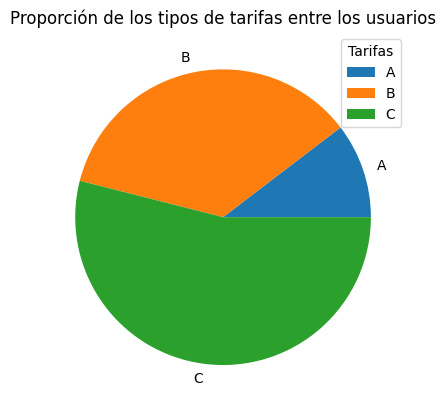

In [131]:
# traza un grafico circular para mostrar la proporcion de los tipos de tarifas entre los usuarios

tariff_proportions = telecom_clients.groupby('tariff_plan').count().reset_index()

#y = np.array(tariff_proportions['user_id'])

plt.pie(
    tariff_proportions['user_id'],
    labels = tariff_proportions['tariff_plan']
    )


plt.title('Proporción de los tipos de tarifas entre los usuarios')
plt.legend(title='Tarifas')
plt.show()

Podemos observar que la tarifa A es la menos popular, seguida de la tarifa B, destacando la tarifa C como la más contratada, ocupando más del 50% de la proporción del total 

### Cantidad de usuarios que iniciaron de cada mes

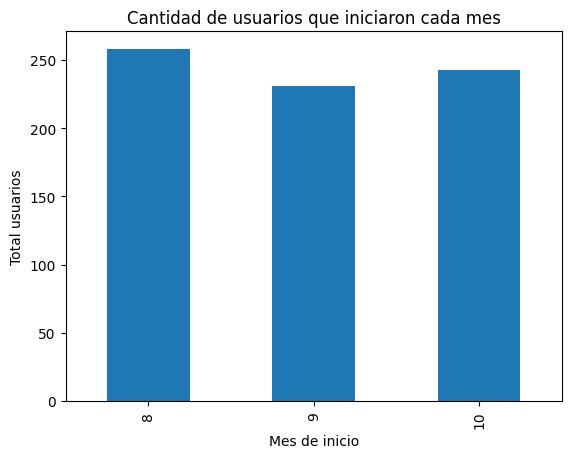

In [143]:
# traza gráfico para mostrar la cantidad de usuarios que inciaron en cada mes. 
# Eje X debería tener cada mes, y eje Y la cantidad de usuarios que empezaron en ese mes.

telecom_clients['month_start'] = telecom_clients['date_start'].dt.month

total_users_by_month = telecom_clients.groupby('month_start')['user_id'].nunique().reset_index()

total_users_by_month.plot(

   kind= 'bar',
   x= 'month_start',
   y=  'user_id',
   legend = False,
   xlabel = 'Mes de inicio',
   ylabel = 'Total usuarios',
   title = 'Cantidad de usuarios que iniciaron cada mes'
)

plt.show()

En el mes de Agosto se iniciaron más usuarios que en los siguientes dos meses. Sin embargo la diferencia no es significativa, la cantidad entre los meses se encuentra en un rango relativamente pequeño, entre 225 a 260 usuarios. 

### Cantidad de llamadas IN vs OUT

In [147]:
in_out_calls_total = telecom_dataset.groupby(['direction','call_month']).agg({'calls_count':'sum'}).reset_index()

in_out_calls_total

,direction,call_month,calls_count
0,in,8,4730
1,in,9,26403
2,in,10,86399
3,in,11,99103
4,out,8,36581
5,out,9,135370
6,out,10,263080
7,out,11,234855


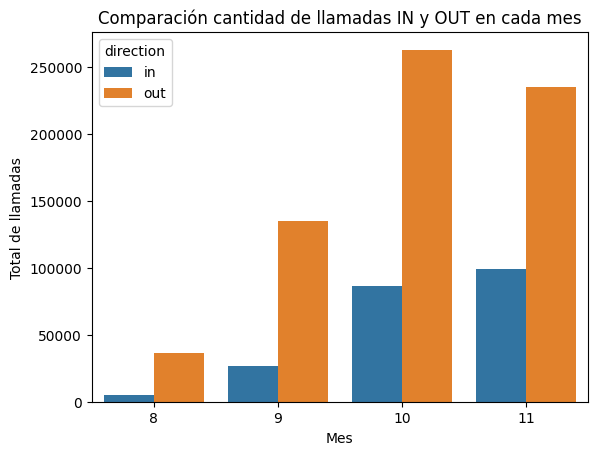

In [152]:
# gráfico de barras

sns.barplot(in_out_calls_total, x= 'call_month', y='calls_count', hue='direction')

plt.title('Comparación cantidad de llamadas IN y OUT en cada mes')
plt.xlabel('Mes')
plt.ylabel('Total de llamadas')

plt.show()

Teniendo en cuenta que cada mes se iniciaron más usuarios, es de esperar que cada mes se registren más llamadas in y out que el mes anterior, tal como lo vemos en la gráfica. Podemos confirmar que los operadores realizan muchas más llamadas externas (out), que internas (in). 

### Llamadas perdidas por operador

In [10]:
# Para cada operador, encuentra el número de llamadas entrante perdidas. Agrupa usando el método groupby(). 

in_missed_calls = (
    telecom_dataset[(telecom_dataset['is_missed_call'] == True) & (telecom_dataset['direction'] == 'in')]
    .groupby('operator_id').agg({'calls_count':'sum'})
    .sort_values(by='calls_count',ascending = False)
    .rename(columns={'calls_count':'missed_calls_count'})
    .reset_index()
)

display(in_missed_calls.head())

C:\Users\david\AppData\Local\Temp\ipykernel_23088\2682867645.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('operator_id').agg({'calls_count':'sum'})


,operator_id,missed_calls_count
0,913942.0,55
1,944226.0,38
2,944216.0,32
3,940588.0,30
4,885890.0,27


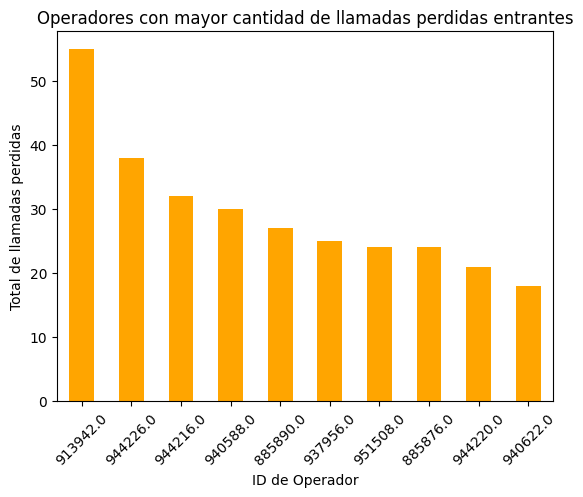

In [11]:
# Traza un gráfico de barras, organizado de mayor a menor.

in_missed_calls_graph = in_missed_calls.head(10)

in_missed_calls_graph.plot(
    kind = 'bar',
    x= 'operator_id',
    y= 'missed_calls_count',
    title = 'Operadores con mayor cantidad de llamadas perdidas entrantes',
    xlabel = 'ID de Operador',
    ylabel = 'Total de llamadas perdidas',
    color = 'orange',
    legend = False,
    rot = 45
)

plt.show()


Podemos determinar que los diez operadores con la mayor cantidad de llamadas perdidas son: 913942, 944226, 944216, 940588, 885890, 937956, 951508, 885876, 944220 y 940622.  

En primer lugar, destaca el operador 913942 con 55 llamadas perdidas, lo cual es 17 llamadas perdidas más que el operador que le sigue. 

Determinaremos que un operador es ineficaz cuando presenta más de 10 llamadas perdidas. 

### Tiempo de espera de llamadas entrantes promedio por operador

In [12]:
# Para cada operador, encuentra el tiempo de espera de llamadas entrantes. 

# Creamos una nueva columna en el dataset telecom_dataset para el tiempo de espera
# restando del tiempo total de llamada, el tiempo de llamada. 

telecom_dataset['call_wait_duration'] = telecom_dataset['total_call_duration'] - telecom_dataset['call_duration']

# Luego utiliza el método groupby(). 

waiting_time_in_calls = (
    telecom_dataset[telecom_dataset['direction'] == 'in']
    .groupby('operator_id').agg({'call_wait_duration':'mean'})
    .sort_values(by='call_wait_duration',ascending = False)
    .rename(columns={'call_wait_duration':'call_wait_average'})
    .reset_index()
)

waiting_time_in_calls = waiting_time_in_calls.dropna()

waiting_time_in_calls['call_wait_average'] = waiting_time_in_calls['call_wait_average'].astype('int')

display(waiting_time_in_calls.head())

C:\Users\david\AppData\Local\Temp\ipykernel_23088\3338812637.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('operator_id').agg({'call_wait_duration':'mean'})


,operator_id,call_wait_average
0,919794.0,1039
1,906070.0,853
2,919790.0,839
3,931458.0,655
4,906076.0,611


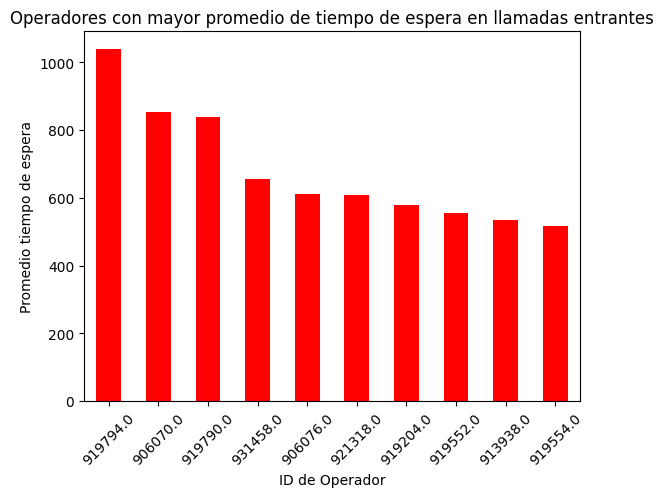

In [13]:
# Realiza un gráfico de barras, organizado de mayor a menor.

waiting_time_in_calls_graph = waiting_time_in_calls.head(10)

waiting_time_in_calls_graph.plot(
    kind = 'bar',
    x= 'operator_id',
    y= 'call_wait_average',
    title = 'Operadores con mayor promedio de tiempo de espera en llamadas entrantes',
    xlabel = 'ID de Operador',
    ylabel = 'Promedio tiempo de espera',
    color = 'red',
    legend = False,
    rot = 45
)

plt.show()

Podemos determinar que los diez operadores con la mayor cantidad de llamadas perdidas son: 919794, 906070, 919790, 931458, 906076, 921318, 919204, 919552, 913938 y 919554.

En primer lugar, destaca el operador 919794 con un tiempo de espera de 1039 segundos, lo cual es 186 segundos más que el operador que le sigue.

Determinaremos que un operador se considerea ineficaz cuando presenta un promedio de tiempo de espera en sus llamadas de más de 100 segundos. 

### Cantidad total de llamadas salientes por operador

In [106]:
# Para cada operador, encuentra la cantidad total de llamdas salientes cada mes. Utiliza método groupby()

telecom_dataset['call_month'] = telecom_dataset['date_only'].dt.month

out_calls_total_per_moth = (
    telecom_dataset[telecom_dataset['direction'] == 'out']
    .groupby(['operator_id','call_month']).agg({'calls_count':'sum','call_duration':'sum'})
    .sort_values(by='operator_id',ascending = True)
    .rename(columns={'calls_count':'total_out_calls'})
    .reset_index()
)

out_calls_total_per_moth

C:\Users\david\AppData\Local\Temp\ipykernel_23088\1147144371.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['operator_id','call_month']).agg({'calls_count':'sum','call_duration':'sum'})


,operator_id,call_month,total_out_calls,call_duration
0,879896.0,8,886,62476
1,879896.0,9,106,11890
2,879896.0,10,69,2746
3,879896.0,11,10,487
4,879898.0,8,1788,88897
...,...,...,...,...
4363,973120.0,10,0,0
4364,973286.0,9,0,0
4365,973286.0,10,0,0
4366,973286.0,8,0,0


In [110]:
# para cada operador, encuentra el promedio de llamadas salientes al mes

out_calls_total_per_moth_avg = (
    out_calls_total_per_moth.groupby('operator_id').mean()[['total_out_calls','call_duration']]
    .reset_index()
    .sort_values(by='total_out_calls')
    .rename(columns={'total_out_calls':'monthly_avg_out_calls'})
)

out_calls_total_per_moth_avg

C:\Users\david\AppData\Local\Temp\ipykernel_23088\1890911137.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out_calls_total_per_moth.groupby('operator_id').mean()[['total_out_calls','call_duration']]


,operator_id,monthly_avg_out_calls,call_duration
1091,973286.0,0.00,0.0
620,932460.0,0.00,0.0
614,931914.0,0.00,0.0
607,930818.0,0.00,0.0
196,901350.0,0.00,0.0
...,...,...,...
317,908640.0,4174.75,80139.0
551,925922.0,5438.50,223354.0
583,929428.0,6143.00,73400.0
29,885890.0,16163.25,894927.5


In [111]:
# Cuántos operadores en total hay que no realizan llamadas salientes? 

list_of_operators_with_no_calls = out_calls_total_per_moth_avg[out_calls_total_per_moth_avg['monthly_avg_out_calls'] == 0]['operator_id']

print('Hay', len(list_of_operators_with_no_calls) , 'operadores con un promedio de llamadas salientes mensual de 0.')

Hay 210 operadores con un promedio de llamadas salientes mensual de 0.


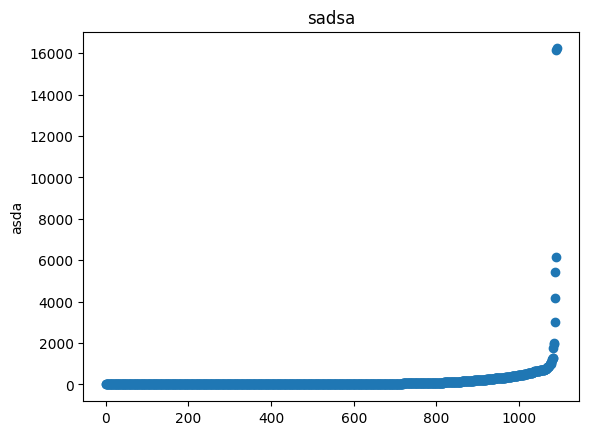

In [112]:
# realiza gráfico de distribución 

x_scatter_len = pd.Series(range(0,len(out_calls_total_per_moth_avg)))

plt.scatter(
    x_scatter_len,
    out_calls_total_per_moth_avg['monthly_avg_out_calls'],
)

plt.title('sadsa')
plt.ylabel('asda')

plt.show()

In [158]:
# cuántos operadores hay que hayan realizado menos de 200 llamadas?

list_of_operators_with_low_calls = out_calls_total_per_moth_avg[out_calls_total_per_moth_avg['monthly_avg_out_calls'] < 100]['operator_id']

print('Hay', len(list_of_operators_with_low_calls) , 'operadores en total que han realizado menos de 100 llamadas salientes al mes en promedio.')

Hay 822 operadores en total que han realizado menos de 100 llamadas salientes al mes en promedio.


Podemos observar que la cantidad de llamadas salientes, aunque varía de mes a mes, hemos realizado un promedio por operador de las llamadas realizadas entre todos los meses, para así realizar un estimado de cuál sería el marcador indicativo de un operador ineficaz en esta métrica. Hemos determinado entonces que un operador se considerará ineficaz cuando tenga un promedio de llamadas realizadas en todos los meses de menos de 100. 

### Distribución de duración de llamadas vs cantidad de llamadas por operador

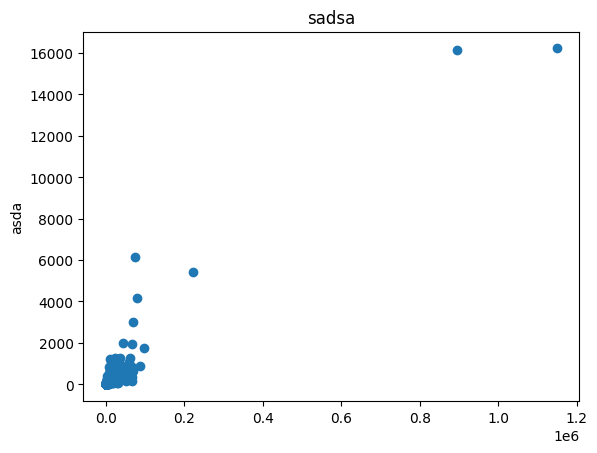

In [114]:
plt.scatter(
    out_calls_total_per_moth_avg['call_duration'],
    out_calls_total_per_moth_avg['monthly_avg_out_calls'],
)

plt.title('sadsa')
plt.ylabel('asda')

plt.show()


Reafirmamos lo que anteriormente hemos deducido a partir de la matriz de correlaciones del conjunto de datos telecom_dataset. Cuando un operador realiza más llamadas, lo más seguro es que logra conectar con más personas al otro lado de la línea, resultando en un promedio de duración de llamada más alto. 

A menos intentos de llamadas realizadas, más intentos de llamadas que no conectan con la otra persona y duran 0 segundos. 

### ¿Cuáles son los operadores con menor eficacia? 

Detecta, de la lista de operadores que no han realizado llamadas, cuáles también se encuentran en la lista de operadores con alto tiempo de espera promedio, y alta cantidad de llamadas entrantes perdidas determinamos.

De acuerdo a los gráficos anteriores recordamos que los marcadores de ineficacia que han definido así:
- un alto número de llamadas perdidas es a partir de 10
- una alta espera en llamadas entrantes, es más de 100 segundos
- una poca cantdad de llamadas salientes, es menos de 100 al mes en promedio

In [159]:

# realiza listas de operadores de acuerdo a cada marcador de ineficacia

operators_with_high_missed_in_calls = in_missed_calls[in_missed_calls['missed_calls_count'] > 10]
operators_with_high_wait_time = waiting_time_in_calls[waiting_time_in_calls['call_wait_average'] > 100]
operators_with_low_calls = out_calls_total_per_moth_avg[out_calls_total_per_moth_avg['monthly_avg_out_calls'] < 100]

# idea 1: concatenar todas las listas con concat(), y luego drop duplicates

ineficient_operators = pd.concat(
    [operators_with_high_missed_in_calls,operators_with_high_wait_time,operators_with_low_calls],
    join = 'inner'
    )

ineficient_operators.drop_duplicates()


,operator_id
0,913942.0
1,944226.0
2,944216.0
3,940588.0
4,885890.0
...,...
471,919910.0
426,919128.0
635,933806.0
138,896382.0


## Parte 4: Probar las hipótesis estadísticamente

Vamos a usar una prueba estadística para evaluar la siguiente hipótesis: la media de llamadas entrantes perdidas de los dos operadores será igual.

Vamos a tomar los dos operadores que más cantidad de llamadas perdidas tiene, según el analisis anterior: 

Operador 913942.0 - Llamadas perdidas 55
Operador 944226.0 - Llamadas perdidas 38

Establecemos alpha = 0.5


In [16]:
# Crea dos arrays de datos de llamadas entrantes perdidas para dos operadores.

operator_913942 = np.array(telecom_dataset[(telecom_dataset['direction'] == 'in') & (telecom_dataset['is_missed_call'] == True) & (telecom_dataset['operator_id'] == 913942.0)]['calls_count'])
operator_944226 = np.array(telecom_dataset[(telecom_dataset['direction'] == 'in') & (telecom_dataset['is_missed_call'] == True) & (telecom_dataset['operator_id'] == 944226.0)]['calls_count'])

# Utiliza una prueba estadística para determinar si la media será igual o diferente.

alpha = 0.5

results = st.ttest_ind(operator_913942, operator_944226)

# resultados t_test

print('valor p:', results.pvalue)
# tu código: imprime el valor p obtenido

# su código: compara los valores p obtenidos con el nivel de significación estadística
if (results.pvalue < alpha):
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")


valor p: 0.27635761691671784
Rechazamos la hipótesis nula


## Parte 5: Conclusiones finales y recomendaciones para CallMeMaybe

Hemos observado en primera instancia, que ha habido un crecimiento mes a mes de usuarios uniforme. Cada mes se registraron una cantidad similar a diferentes tarifas. Entre las tarifas, la más popular es la C, y se realizan muchas más llamadas en dirección externa que interna.

Ya que cada mes han habido más usuarios que el anterior, hemos realizado el análisis de los indicadores de ineficacia a partir de promedios que toman en cuenta todos los meses, para así sacar estimados. 

De acuerdo a nuestro análisis, las recomendaciones finales serán considerar a un operador como ineficaz, cuando cumpla con una o más de las siguientes condiciones: 

- Promedio de llamadas perdidas mayor a 10
- Promedio de tiempo de espera en llamadas entrantes mayor a 100 segundos
- Promedio mensual de llamadas externas menor a 100

A partir de nuestro estudio estadístico, hemos visto que debemos rechazar la hipótesis de que el indicador de eficiencia 'media de llamadas entrantes perdidas' será igual entre operadores. Por esto podemos esperar que se presenten diferencias estadísticas en las diferentes métricas de eficiencia al momento de comparar operadores. Implementar esta función para indentificar aquellos operadores que no cumplen las expectativas será beneficioso para los supervisores y las supervisoras, para así tomar acciones correctivas a tiempo.

Una posible acción que de momento podríamos sugerir, sería alentar a los usuarios a realizar más llamadas, ya que aquellos operadores que registran más intentos de llamadas, reportan mayor uso del servicio en cuanto a duración de llamadas. Sugerimos también informar a los equipos de marketing sobre la diferencia entre preferencia de tarifa que hemos encontrado entre los usuarios, ya que mientras el C es popular, el A ocupa una proporción bastante baja. Recomendamos considerar si este plan vale la pena el costo que supone ofertarlo, o si requiere alguna mejora tal vez. 

Encuentra una presentación en PDF sobre este proyecto aquí: https://docs.google.com/presentation/d/1PlbUOwyWQr36LSuUtyLUTgq4A5lMktAXn6swogzeMgA/edit?usp=sharing